# 3-6. 프로젝트: 고양이 수염 스티커 만들기

### [루브릭]

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항 및 상세기준
1. 자기만의 카메라앱 기능 구현을 완수하였다. 
    - 원본에 스티커 사진이 정상적으로 합성되었다.
2. 스티커 이미지를 정확한 원본 위치에 반영하였다. 
    - 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.
3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다. 
    - 얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.
    
### [학습 과정]
1. 스티커 구하기 or 만들기
2. 얼굴 검출 & 랜드마크 검출 하기
3. 스티커 적용 위치 확인하기
4. 스티커 적용하기
5. 문제점 찾아보기

### 환경설정 해주기

In [1]:
import cv2
import matplotlib.pyplot as plt
import PIL.Image as pilimg
import numpy as np
import os
import dlib
print("🌫🛸") # 이미지 잘 읽어오는지 확인

🌫🛸


### 스티커 구하기

구글에 cat whiskers png 라고 검색한 뒤 가장 귀여운 고양이 수염 이미지를 다운받았습니다.

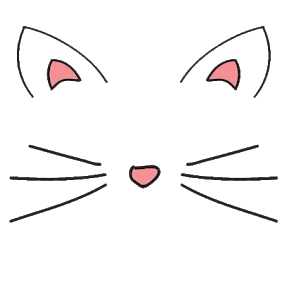

In [2]:
catSticker = pilimg.open('/home/ssac18/project/AIFFEL/E03_CameraSticker/images/catWhiskers.png')
catSticker

짠!      
고양이 귀도 달려있는 스티커입니다.

### 얼굴 검출, 랜드마크 검출

스티커를 적용하고자 하는 이미지를 가져오겠습니다.  

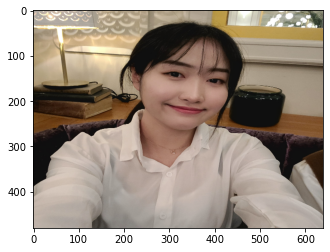

In [3]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/IMG_20201024_202505_572.jpg'
img_bgr = cv2.imread(my_img_path)  #OpenCV로 이미지 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    #640x480 크기로 resize
img_show = img_bgr.copy()     #출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #bgr로 된 이미지를 rgb를 적용해줌
plt.imshow(img_rgb)
plt.show()    

OpenCV로 이미지를 읽어서 -> 사진 크기 조정 -> bgr이 적용된 이미지를 rgb로 적용해줌 -> 이미지 픽셀값들의 배열로 반환

### 얼굴 검출, 랜드마크 검출

### face detection

dlib에서 정면 얼굴을 인식하는 함수(get_frontal_face_detector())를 가져와 얼굴을 인식한 뒤 얼굴영역을 따라 초록색 사각형을 그려주었습니다.

rectangles[[(241, 68) (464, 291)]]


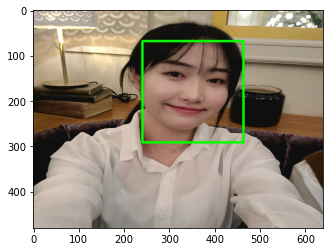

In [4]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   
    #- (이미지 파일, 이미지 피라미드의 개수)
print(dlib_rects) # 찾은 얼굴영역 좌표


# face box 그리기
# 얼굴영역의 좌표 값을 1씩 옮기면서 좌표 찾기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 3, lineType = cv2.LINE_AA)
        # 이미지 파일, 시작점(왼쪽 위 꼭지점), 종료점(오른쪽 아래 꼭지점)을 잡고 사각형을 그려줍니다.
        # 색상은 초록색 (0, 255, 0)
        # 선 두께 3

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 랜드마크 모델

랜드마크 모델을 활용하여 얼굴 랜드마크 지점마다 점을 찍어줍니다.

In [5]:
# 저장한 landmark 모델 불러오기

model_path = os.getenv('HOME')+'/project/AIFFEL/E03_CameraSticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [6]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


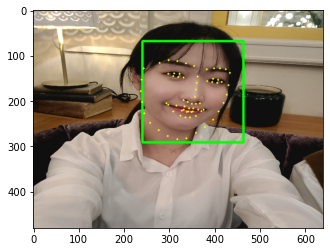

In [7]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)  # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 스티커 적용 위치 확인하기

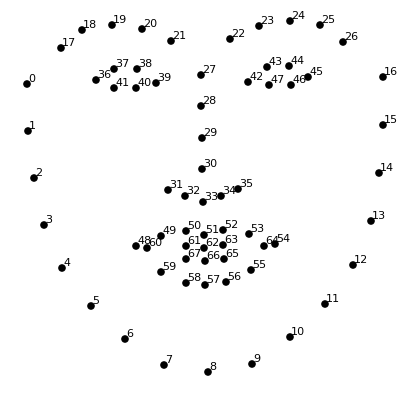

In [8]:
points = pilimg.open('/home/ssac18/project/AIFFEL/E03_CameraSticker/images/points.png')
points

위 사진에서 보듯 코 중심점의 랜드마크 숫자는 30입니다. 고양이 수염스티커는 코에다 붙여햐하기 때문에 우선 코 중심점의 좌표를 확인합니다. 스티커가 사진에 잘 어울리도록 좌표 조정을 해주겠습니다.

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])      # 코 중심점 : 30
    x = landmark[30][0]      # 30번 랜드마크(코 중심)의 x 좌표
    y = landmark[30][1]      # 30번 랜드마크(코 중심)의 y 좌표
    w = dlib_rect.width()    # 너비
    h = dlib_rect.width()    # 높이
    print('30번 랜드마크(코 중심)의 좌표 (x,y) : (%d,%d)'%(x,y))
    print('얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (%d,%d)'%(w,h))

(357, 191)
30번 랜드마크(코 중심)의 좌표 (x,y) : (357,191)
얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (224,224)


#### 스티커 크기 조정

스티커 이미지를 불러온 다음, 스티커의 크기를 조정해주었습니다.  
제가 가져온 스티커의 특징상 고양이 귀까지 얼굴에 맞아야 하기 때문에 얼굴영역보다 약간 크게 사이즈를 잡았습니다.   
인식한 얼굴 영역보다 너비는 50만큼 늘리고 높이는 200만큼 키웠습니다.   

In [10]:
sticker_path = os.getenv('HOME') + '/project/AIFFEL/E03_CameraSticker/images/catWhiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w+50,h+200))    # 스티커 크기 조정.
print(img_sticker.shape)

(424, 274, 3)


#### 스티커 위치 조정

얼굴 이미지에 맞춰서 조금씩 위치를 조정하고, 결과를 확인하면서 알맞는 위치를 찾아주었습니다.   


In [11]:
# 스티커 위치 조정
# 코 위치를 중심으로 
refined_x = x - 150     #left 
refined_y = y + 170       #top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (207,361)


In [12]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(361, 274, 3)


In [13]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (207,0)


### 스티커 적용하기

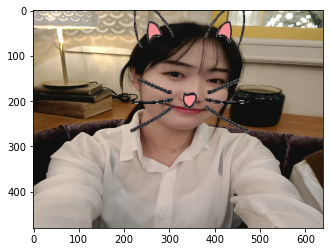

In [14]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], 
                       refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], 
        refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

정면을 바라보고 있는 얼굴 이미지가 아주 잘 인식된 것을 확인했습니다. 다른 조건의 이미지에서도 얼굴인식이 잘 되고 스티커가 잘 적용되는지 확인해보기 위해 다음과 같은 이미지를 구하였습니다.

## 다른 이미지로 해보기
1. __같은 이미지에 변형을 넣어준 이미지__
    * grayscale
    * rotated   
    
2. __다른 이미지__
    * 얼굴이 멀리있는 (촬영 거리가 먼) 이미지
    * 눈이 잘 안보이는 얼굴 (안경, 찡그린 표정)
    * 사이드 얼굴
    * 얼굴 각도가 45도
    * 빛이 많은 이미지  

3. __얼굴이 2개 이상인 이미지__

4. __사람이 아닌 얼굴 이미지__
    * 캐릭터 얼굴
    * 동물 얼굴
    
위의 다양한 이미지에서 얼굴이 잘 인식되는지 확인하고, 인식에 있어 가장 중요하게 작용하는 요인에 대해 분석합니다.

### 1. 같은 이미지에 변형을 넣어준 이미지 - grayscale

얼굴 인식을 할 때 컬러 유무는 얼마나 중요하게 작용하는가??를 알아보기 위해

기존 이미지를 흑백으로 변경한 다음 얼굴을 잘 인식하는지 확인해보겠습니다.

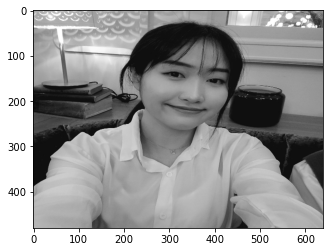

In [126]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/IMG_20201024_202505_572.jpg'
img_bgr = cv2.imread(my_img_path, cv2.IMREAD_GRAYSCALE)  #OpenCV로 이미지를 흑백으로 읽어오기
img_bgr = cv2.resize(img_bgr, (640, 480))    #640x480 크기로 resize
img_show = img_bgr.copy()     #출력용 이미지 별도 보관
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_gray)
plt.show()    

rectangles[[(251, 80) (443, 273)]]


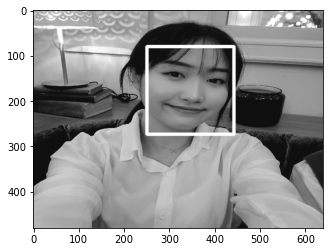

In [127]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_gray, 2)   
print(dlib_rects) # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (255, 255, 255), 5, lineType = cv2.LINE_AA)
        # 색상은 흰색 (255, 255, 255)
        # 선 두께 5

img_show_gray = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_gray)
plt.show()

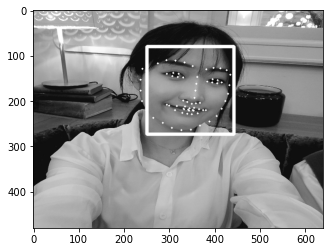

In [128]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_gray, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (255, 255, 255), -1)  # white

img_show_gray = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_gray)
plt.show()

__정말 신기하게도 원본 이미지보다 얼굴 경계를 잘 인식합니다.__ 아마 흑백처리하면서 명암이 뚜렷하게 나타나 얼굴 경계를 잘 인식하게 된 것 같습니다.   
그래서 위와 같은 이미지이지만  불가피하게 스티커 위치 좌표를 조정해줘야 했습니다.

In [129]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])      # 코 중심점 : 30
    x = landmark[30][0]      # 30번 랜드마크(코 중심)의 x 좌표
    y = landmark[30][1]      # 30번 랜드마크(코 중심)의 y 좌표
    w = dlib_rect.width()    # 너비
    h = dlib_rect.width()    # 높이
    print('30번 랜드마크(코 중심)의 좌표 (x,y) : (%d,%d)'%(x,y))
    print('얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (%d,%d)'%(w,h))

(356, 193)
30번 랜드마크(코 중심)의 좌표 (x,y) : (356,193)
얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (193,193)


In [130]:
sticker_path = os.getenv('HOME') + '/project/AIFFEL/E03_CameraSticker/images/catWhiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w+50,h+200))   
print(img_sticker.shape)

(393, 243, 3)


In [131]:
#스티커 위치 약간 조정
refined_x = x - 130     #left 
refined_y = y + 150       #top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (226,343)


In [132]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(343, 243, 3)


In [133]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (226,0)


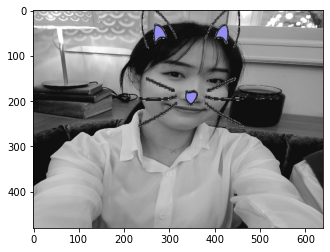

In [134]:
sticker_area = img_gray[refined_y:img_sticker.shape[0], 
                       refined_x:refined_x+img_sticker.shape[1]]
img_gray[refined_y:img_sticker.shape[0], 
        refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
#plt.imshow(cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB))
plt.imshow(img_gray)
plt.show()

결과적으로 얼굴은 더욱 잘 인식되었지만 스티커의 색깔이 같이 변했습니다. 

### 1. 같은 이미지에 변형을 넣어준 이미지 - rotated 
얼굴 인식할 때 얼굴 방향이 정 방향이 아니어도 되는가??에 대해 의문이 생겼습니다. '눈, 코 입 등등 이목구비를 이루는 픽셀이 동일하고(위치는 다르지만) 그 모양 자체는 같기 때문에 인식할 수 있지 않을까' 라는 생각의 흐름대로, 얼굴 인식과정이 방향 상관없이 이루어지는지 확인해보려 했습니다.    우선, 회전 행렬 함수(cv2.getRotationMatrix2D())를 통해 원하는 회전 각만큼 이미지를 선형변환시켰습니다.   
아래는 __기존 이미지를 시계 방향으로 180도 회전한 이미지__ 를 input으로 넣어준 결과입니다.

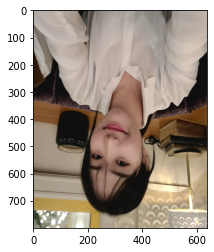

In [24]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/IMG_20201024_202505_572.jpg'
img_bgr = cv2.imread(my_img_path)  #OpenCV로 이미지 읽음

height, width = img_bgr.shape[:2]
matrix = cv2.getRotationMatrix2D((height/2, width/2), 180, 1)
img_bgr = cv2.warpAffine(img_bgr, matrix, (width, height))


img_bgr = cv2.resize(img_bgr, (640, 800))    #640x480 크기로 resize
img_show = img_bgr.copy()     #출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #bgr로 된 이미지를 rgb를 적용해줌
plt.imshow(img_rgb)
plt.show()    

rectangles[[(167, 489) (390, 712)]]


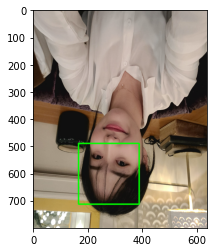

In [25]:
detector_hog = dlib.get_frontal_face_detector()   #-정면 얼굴 검출기
dlib_rects = detector_hog(img_rgb, 1)   
    #- (이미지 파일, 이미지 피라미드의 개수)
print(dlib_rects) # 찾은 얼굴영역 좌표


# face box 그리기
# 얼굴영역의 좌표 값을 1씩 옮기면서 좌표 찾기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (r,b), (l,t), (0, 255, 0), 3, lineType = cv2.LINE_AA)
        # 이미지 파일, 시작점(왼쪽 위 꼭지점), 종료점(오른쪽 아래 꼭지점)을 잡고 사각형을 그려줍니다.
        # 색상은 초록색 (0, 255, 0)
        # 선 두께 3

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

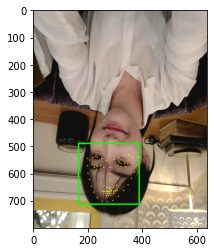

In [26]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)  # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

처음 이미지 크기를 그대로 적용(640x480)했을 때는 얼굴을 인식하지 못했습니다. 그러나 __이미지 사이즈를 640x800으로 세로 이미지에 맞는 비율로 resizing__ 해주었더니 얼굴을 어느 정도 인식합니다! 랜드마크를 그려보니 눈의 위치는 정확하게 인식했지만 나머지 이목구비와 얼굴 경계는 눈의 위치에 대해 임의로 정방향으로 그리는 것을 알 수 있습니다. 

### 2-1. 얼굴이 멀리 있는(촬영 거리가 먼) 이미지
최소 촬영 거리가 어느정도여야 하는지 확인해 보려고 합니다. 일반적으로 팔 길이만큼의 촬영 거리를 두고 찍는 얼굴 사진보다 좀 더 멀리 있는 얼굴을 얼마나 잘 인식하는지 확인하려 합니다.

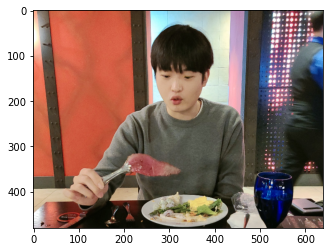

In [27]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/bf.jpg'
img_bgr = cv2.imread(my_img_path)  #OpenCV로 이미지 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    #640x480 크기로 resize
img_show = img_bgr.copy()     #출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #bgr로 된 이미지를 rgb를 적용해줌
plt.imshow(img_rgb)
plt.show()    

rectangles[[(259, 116) (366, 223)]]


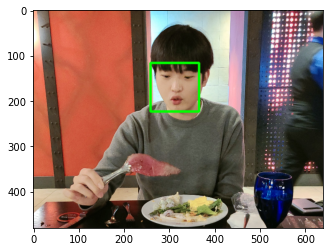

In [28]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   
    #- (이미지 파일, 이미지 피라미드의 개수)
print(dlib_rects) # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 3, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

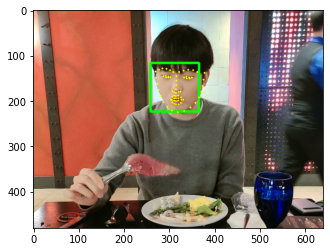

In [29]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)  # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [30]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])      # 코 중심점 : 30
    x = landmark[30][0]      # 30번 랜드마크(코 중심)의 x 좌표
    y = landmark[30][1]      # 30번 랜드마크(코 중심)의 y 좌표
    w = dlib_rect.width()    # 너비
    h = dlib_rect.width()    # 높이
    print('30번 랜드마크(코 중심)의 좌표 (x,y) : (%d,%d)'%(x,y))
    print('얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (%d,%d)'%(w,h))
    
sticker_path = os.getenv('HOME') + '/project/AIFFEL/E03_CameraSticker/images/catWhiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w+50,h+170))    # 스티커 크기 조정.
print('스티커 이미지 shape: ', img_sticker.shape)

(315, 174)
30번 랜드마크(코 중심)의 좌표 (x,y) : (315,174)
얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (108,108)
스티커 이미지 shape:  (278, 158, 3)


In [31]:
refined_x = x - 80     #left 
refined_y = y + 200       #top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (235,374)


In [32]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(278, 158, 3)


In [33]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (235,0)


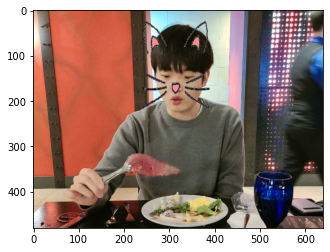

In [34]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], 
                       refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], 
        refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

촬영거리가 팔길이의 2배 더 멀리 있는 얼굴도 잘 인식합니다.   
더 멀리있는 이미지를 확인해보겠습니다.   
아래는 __전신 사진__ 인데요, 한 프레임에 전신이 담길만큼 멀리서 촬영된 얼굴을 얼마나 잘 인식하는지 확인하겠습니다. 앞서 이미지 비율을 조절하는 것이 중요하다는 것을 알았으니 앞으로 나오는 세로 이미지들은 비율을 600x800 으로 맞추도록 하겠습니다.

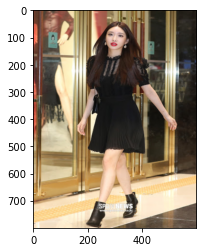

In [35]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/smallface.jpg'
img_bgr = cv2.imread(my_img_path)  #OpenCV로 이미지 읽어서
img_bgr = cv2.resize(img_bgr, (600, 800))    #640x480 크기로 resize
img_show = img_bgr.copy()     #출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #bgr로 된 이미지를 rgb를 적용해줌
plt.imshow(img_rgb)
plt.show()    

rectangles[[(262, 72) (337, 146)]]


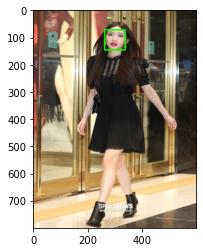

In [36]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   
    #- (이미지 파일, 이미지 피라미드의 개수)
print(dlib_rects) # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 3, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

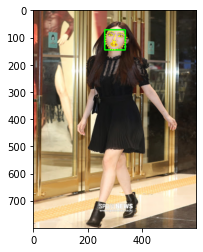

In [37]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)  # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [38]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])      # 코 중심점 : 30
    x = landmark[30][0]      # 30번 랜드마크(코 중심)의 x 좌표
    y = landmark[30][1]      # 30번 랜드마크(코 중심)의 y 좌표
    w = dlib_rect.width()    # 너비
    h = dlib_rect.width()    # 높이
    print('30번 랜드마크(코 중심)의 좌표 (x,y) : (%d,%d)'%(x,y))
    print('얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (%d,%d)'%(w,h))
    
sticker_path = os.getenv('HOME') + '/project/AIFFEL/E03_CameraSticker/images/catWhiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h+100))    # 스티커 크기 조정.
print('스티커 이미지 shape: ', img_sticker.shape)


(297, 108)
30번 랜드마크(코 중심)의 좌표 (x,y) : (297,108)
얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (76,76)
스티커 이미지 shape:  (176, 76, 3)


In [39]:
refined_x = x - 35     #left 
refined_y = y - 45       #top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (262,63)


In [40]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (262,0)


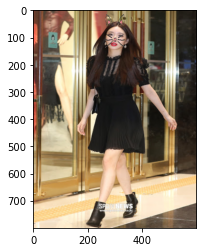

In [41]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], 
                       refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], 
        refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

스티커 위치를 다시 조정해주어야 했으나 전신 사진에서도 얼굴을 잘 인식합니다!

### 2-2. 눈이 잘 안보이는 이미지 (안경, 찡그린 표정)
우선, 안경에 눈이 가려 잘 안보이는 이미지를 가져왔습니다. 이 경우에도 잘 인식이 되는지 확인해보겠습니다.

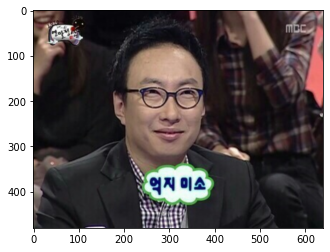

In [42]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/glasses.jpg'
img_bgr = cv2.imread(my_img_path)  #OpenCV로 이미지 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    #640x480 크기로 resize
img_show = img_bgr.copy()     #출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #bgr로 된 이미지를 rgb를 적용해줌
plt.imshow(img_rgb)
plt.show()   

rectangles[[(201, 139) (386, 325)]]


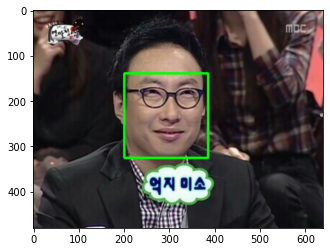

In [43]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   
print(dlib_rects) # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 3, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

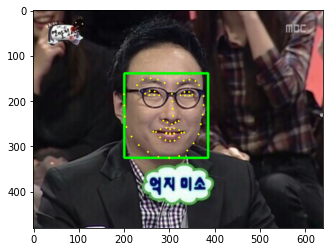

In [44]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)  # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [45]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])      # 코 중심점 : 30
    x = landmark[30][0]      # 30번 랜드마크(코 중심)의 x 좌표
    y = landmark[30][1]      # 30번 랜드마크(코 중심)의 y 좌표
    w = dlib_rect.width()    # 너비
    h = dlib_rect.width()    # 높이
    print('30번 랜드마크(코 중심)의 좌표 (x,y) : (%d,%d)'%(x,y))
    print('얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (%d,%d)'%(w,h))
    
sticker_path = os.getenv('HOME') + '/project/AIFFEL/E03_CameraSticker/images/catWhiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w+50,h+200))    # 스티커 크기 조정.
print('스티커 이미지 shape: ', img_sticker.shape)

(309, 233)
30번 랜드마크(코 중심)의 좌표 (x,y) : (309,233)
얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (186,186)
스티커 이미지 shape:  (386, 236, 3)


In [46]:
refined_x = x - 120     #left 
refined_y = y + 180       #top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (189,413)


In [47]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(386, 236, 3)


In [48]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (189,0)


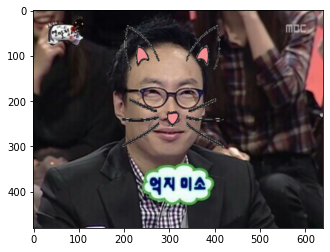

In [49]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], 
                       refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], 
        refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

안경을 써서 눈이 잘 보이지 않는 얼굴도 잘 인식됨을 알 수 있습니다.   
아래는 울상이 되어 눈이 잘 안보이는 이미지입니다. 이 경우에도 잘 인식되는지 확인하겠습니다.

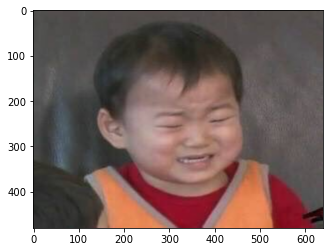

In [50]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/crying.jpg'
img_bgr = cv2.imread(my_img_path)  
img_bgr = cv2.resize(img_bgr, (640, 480))    
img_show = img_bgr.copy()   
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()    

rectangles[[(200, 142) (468, 409)]]


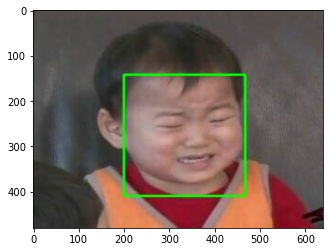

In [51]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   
    #- (이미지 파일, 이미지 피라미드의 개수)
print(dlib_rects) # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 3, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

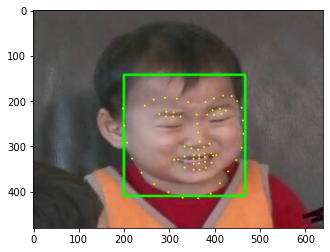

In [52]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)  # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [53]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])      # 코 중심점 : 30
    x = landmark[30][0]      # 30번 랜드마크(코 중심)의 x 좌표
    y = landmark[30][1]      # 30번 랜드마크(코 중심)의 y 좌표
    w = dlib_rect.width()    # 너비
    h = dlib_rect.width()    # 높이
    print('30번 랜드마크(코 중심)의 좌표 (x,y) : (%d,%d)'%(x,y))
    print('얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (%d,%d)'%(w,h))
    
sticker_path = os.getenv('HOME') + '/project/AIFFEL/E03_CameraSticker/images/catWhiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w+50,h+200))    # 스티커 크기 조정.
print('스티커 이미지 shape: ', img_sticker.shape)

(367, 289)
30번 랜드마크(코 중심)의 좌표 (x,y) : (367,289)
얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (269,269)
스티커 이미지 shape:  (469, 319, 3)


In [54]:
refined_x = x - 170     #left 
refined_y = y + 180       #top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (197,469)


In [55]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(469, 319, 3)


In [56]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (197,0)


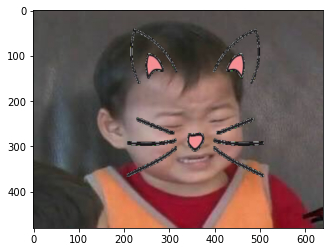

In [57]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], 
                       refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], 
        refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

울상이 되어 눈은 안보여도 얼굴 인식이 잘 되었습니다! 결과적으로 얼굴을 인식하는데 있어서 눈의 위치도 중요하지만 __눈의 위치가 불명확하다고해서 꼭 인식이 잘 안되는 건 아님__ 을 알 수 있습니다.   
나머지 부분, 눈썹과 코, 입 등이 뚜렷하게 나와있다면 눈이 매우 작은 사람도 카메라 스티커앱을 사용하는데 있어 전혀 문제가 없네요..   

### 2-3. 옆얼굴 이미지

이제 얼굴의 각도에 따른 인식률을 확인해보려고 합니다. 완전히 옆모습일 때, 45도 틀어진 각도일 때도 잘 인식하는지 확인하겠습니다.

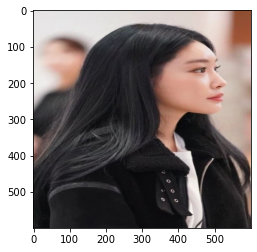

In [58]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/sideface.jpg'
img_bgr = cv2.imread(my_img_path) 
img_bgr = cv2.resize(img_bgr, (600, 600))    
img_show = img_bgr.copy()    
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb)
plt.show()    

rectangles[[(440, 125) (569, 254)]]


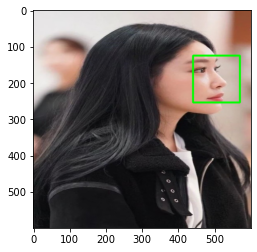

In [59]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   
    #- (이미지 파일, 이미지 피라미드의 개수)
print(dlib_rects) # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 3, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

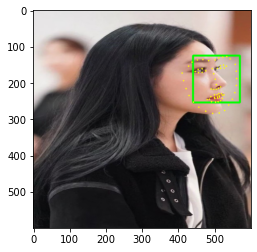

In [60]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)  # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [61]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])      # 코 중심점 : 30
    x = landmark[30][0]      # 30번 랜드마크(코 중심)의 x 좌표
    y = landmark[30][1]      # 30번 랜드마크(코 중심)의 y 좌표
    w = dlib_rect.width()    # 너비
    h = dlib_rect.width()    # 높이
    print('30번 랜드마크(코 중심)의 좌표 (x,y) : (%d,%d)'%(x,y))
    print('얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (%d,%d)'%(w,h))
    
sticker_path = os.getenv('HOME') + '/project/AIFFEL/E03_CameraSticker/images/catWhiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w+50,h+200))    # 스티커 크기 조정.
print('스티커 이미지 shape: ', img_sticker.shape)

(504, 205)
30번 랜드마크(코 중심)의 좌표 (x,y) : (504,205)
얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (130,130)
스티커 이미지 shape:  (330, 180, 3)


In [62]:
refined_x = x  - 90   #left 
refined_y = y + 200  #top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (414,405)


In [63]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(330, 180, 3)


In [64]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (414,0)


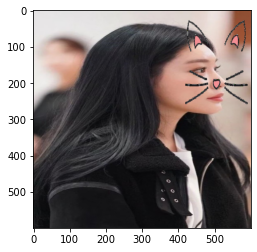

In [65]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], 
                       refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], 
        refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

얼굴 인식은 함! 스티커가 평면적이라서 어색할 뿐

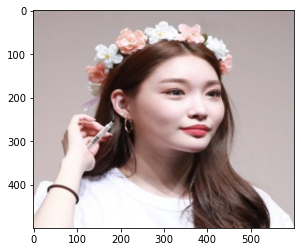

In [66]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/45.jpg'
img_bgr = cv2.imread(my_img_path) 
img_bgr = cv2.resize(img_bgr, (600, 500))    
img_show = img_bgr.copy()     
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb)
plt.show()    

rectangles[[(241, 118) (464, 341)]]


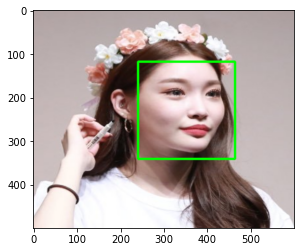

In [67]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   
    #- (이미지 파일, 이미지 피라미드의 개수)
print(dlib_rects) # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 3, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

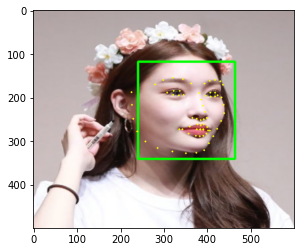

In [68]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)  # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [69]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])      # 코 중심점 : 30
    x = landmark[30][0]      # 30번 랜드마크(코 중심)의 x 좌표
    y = landmark[30][1]      # 30번 랜드마크(코 중심)의 y 좌표
    w = dlib_rect.width()    # 너비
    h = dlib_rect.width()    # 높이
    print('30번 랜드마크(코 중심)의 좌표 (x,y) : (%d,%d)'%(x,y))
    print('얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (%d,%d)'%(w,h))
    
sticker_path = os.getenv('HOME') + '/project/AIFFEL/E03_CameraSticker/images/catWhiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w+50,h+200))    # 스티커 크기 조정.
print('스티커 이미지 shape: ', img_sticker.shape)

(395, 233)
30번 랜드마크(코 중심)의 좌표 (x,y) : (395,233)
얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (224,224)
스티커 이미지 shape:  (424, 274, 3)


In [70]:
refined_x = x-150     #left 
refined_y = y+160    #top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (245,393)


In [71]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(393, 274, 3)


In [72]:
refined_y = 0
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (245,0)


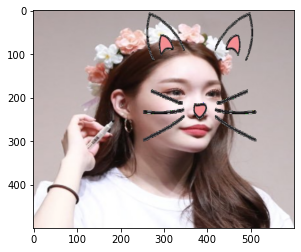

In [73]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], 
                       refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], 
        refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

45도 각도의 얼굴도 잘 인식이 됩니다.

### 2-4. 빛이 많은 이미지
이미지에 빛이 많은 경우 잘 인식하는지 확인해보겠습니다.

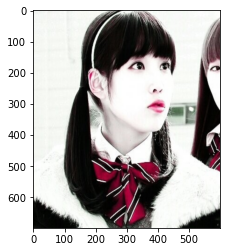

In [74]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/verywhite.jpg'
img_bgr = cv2.imread(my_img_path)  #OpenCV로 이미지 읽어서
img_bgr = cv2.resize(img_bgr, (600, 700))    #640x480 크기로 resize
img_show = img_bgr.copy()     #출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #bgr로 된 이미지를 rgb를 적용해줌
plt.imshow(img_rgb)
plt.show()    

rectangles[]


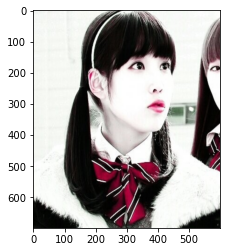

In [75]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   
    #- (이미지 파일, 이미지 피라미드의 개수)
print(dlib_rects) # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 3, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

이미지에 빛이 많으면 얼굴 경계와 이목구비가 뚜렷하지 않아 얼굴 인식이 잘 되지 않습니다.

### 3. 얼굴이 여러개
한 이미지 내에 인식가능한 얼굴이 2개 이상 있을 경우 인식이 잘 되는지 확인합니다.

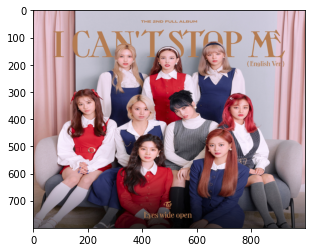

In [94]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/many.jpg'
img_bgr = cv2.imread(my_img_path)  #OpenCV로 이미지 읽어서
img_bgr = cv2.resize(img_bgr, (1000, 800))    #640x480 크기로 resize
img_show = img_bgr.copy()     #출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #bgr로 된 이미지를 rgb를 적용해줌
plt.imshow(img_rgb)
plt.show()

rectangles[[(391, 495) (453, 557)], [(308, 156) (370, 218)], [(460, 156) (522, 218)], [(643, 470) (718, 544)], [(726, 337) (801, 412)], [(633, 142) (695, 205)], [(162, 320) (237, 395)], [(370, 343) (432, 405)]]


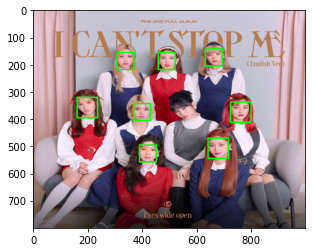

In [95]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   
    #- (이미지 파일, 이미지 피라미드의 개수)
print(dlib_rects) # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 3, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

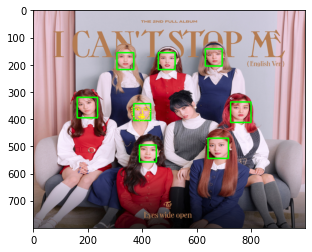

In [96]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmarks in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)  # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

랜드마크가 그려지긴 하나, 하나의 얼굴에 대해서만 그려집니다. 얼굴 각도가 좀 있는 얼굴 제외하고는 모두 인식되었습니다.

### 4-1. 사람이 아닌 얼굴 이미지 - 캐릭터

유명 펭귄 캐릭터인 펭수의 사진을 가져왔습니다. 눈이 들어가있어 명암이 약간 있고 코와 입이 사람의 형태는 아니지만 사람의 이목구비와 비슷하게 생겼습니다. 사람이 아닌 얼굴은 얼마나 잘 인식하는지 보도록 합니다.

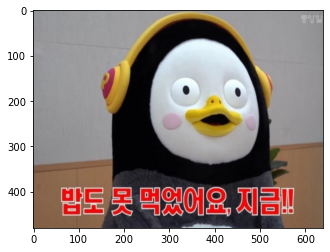

In [81]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/pengsu.jpg'
img_bgr = cv2.imread(my_img_path)  #OpenCV로 이미지 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    #640x480 크기로 resize
img_show = img_bgr.copy()     #출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #bgr로 된 이미지를 rgb를 적용해줌
plt.imshow(img_rgb)
plt.show()    

rectangles[[(291, 93) (513, 316)]]


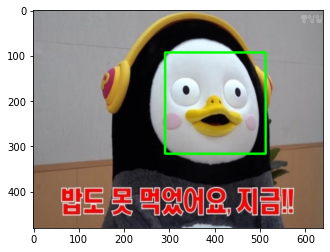

In [82]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   
    #- (이미지 파일, 이미지 피라미드의 개수)
print(dlib_rects) # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 3, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

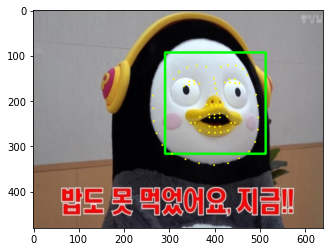

In [83]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)  # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [84]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])      # 코 중심점 : 30
    x = landmark[30][0]      # 30번 랜드마크(코 중심)의 x 좌표
    y = landmark[30][1]      # 30번 랜드마크(코 중심)의 y 좌표
    w = dlib_rect.width()    # 너비
    h = dlib_rect.width()    # 높이
    print('30번 랜드마크(코 중심)의 좌표 (x,y) : (%d,%d)'%(x,y))
    print('얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (%d,%d)'%(w,h))
    
sticker_path = os.getenv('HOME') + '/project/AIFFEL/E03_CameraSticker/images/catWhiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w+50,h+200))    # 스티커 크기 조정.
print('스티커 이미지 shape: ', img_sticker.shape)

(405, 183)
30번 랜드마크(코 중심)의 좌표 (x,y) : (405,183)
얼굴 영역 사각형의 너비와 높이 좌표 (w,h) : (223,223)
스티커 이미지 shape:  (423, 273, 3)


In [85]:
refined_x = x - 140     #left 
refined_y = y + 190       #top
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (265,373)


In [86]:
img_sticker = img_sticker[-refined_y:]
print(img_sticker.shape)

(373, 273, 3)


In [87]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (265,0)


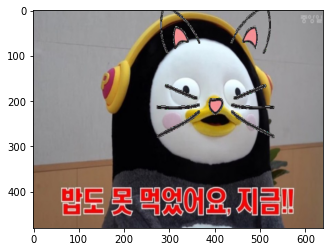

In [88]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], 
                       refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], 
        refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

얼굴 인식이 잘 되었습니다.

### 4-2. 사람이 아닌 이미지 - 동물

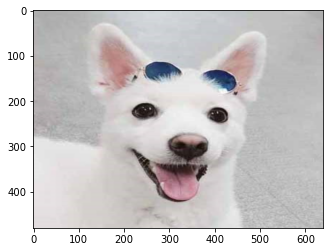

In [89]:
my_img_path = os.getenv('HOME')+ '/project/AIFFEL/E03_CameraSticker/images/doggie.jpg'
img_bgr = cv2.imread(my_img_path)  #OpenCV로 이미지 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    #640x480 크기로 resize
img_show = img_bgr.copy()     #출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #bgr로 된 이미지를 rgb를 적용해줌
plt.imshow(img_rgb)
plt.show() 

rectangles[]


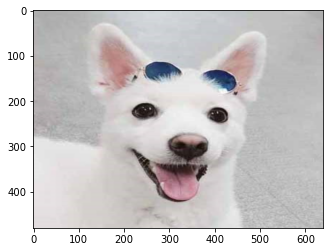

In [90]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   
    #- (이미지 파일, 이미지 피라미드의 개수)
print(dlib_rects) # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()     #가장 왼쪽
    t = dlib_rect.top()      #가장 위쪽 
    r = dlib_rect.right()    #가장 오른쪽 
    b = dlib_rect.bottom()   #가장 밑쪽
    
    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 3, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

사람과 이목구비가 전혀 다른 강아지의 얼굴은 인식을 못합니다. 눈과 코, 입이 모두 있지만 그 생김새가 다르다고 판단합니다.

## 결론 및 회고

결론적으로, 얼굴을 인식하는데 있어서 가장 중요하게 작용하는 변수는 다음과 같습니다.   
* __이목구비 각각보다도 눈썹과 콧대가 잘 드러나 있는가__ 
* __원본 이미지의 비율에 맞게 resize 했는가__
* __명암이 잘 드러나는가 (빛이 너무 많지 않은가)__

저는 다양한 이미지에서 얼굴 인식을 시도하였는데, 위의 조건을 만족하는 대부분의 이미지에서 얼굴을 인식할 수 있었습니다. 전신사진처럼 촬영거리가 멀어도, 이목구비가 반만 보이는 옆모습에서도, 다양한 표정의 얼굴에서도 랜드마크를 잘 찾아내었습니다. 또한 사진의 비율을 조정해주는 것이 얼굴 인식에 있어서 매우 중요했습니다. 세로이미지를 가로 이미지 비율로 불러왔을 때 얼굴 인식에 실패했었던 이미지도 제대로 된 비율로 얼굴 인식을 시도했을 때 성공하기도 했습니다. 

얼굴 인식 모델의 특이점은 :
* __꼭 사람의 얼굴이 아니더라도 눈썹과 콧대 부분의 명암이 잘 드러나 있다면 얼굴 인식 가능__
* __같은 이미지이더라도 컬러 이미지보다 흑백 이미지에서 얼굴 경계를 더 잘 인식__
* __180도 돌아간 이미지에서도 얼굴의 일부분 인식 가능__
* __2명 이상의 얼굴도 인식 가능__
등이 있었습니다.

첫번째 특이점을 찾을 때 캐릭터 이미지를 가지고 오면서도 인식할 거라고 예상은 못했는데, 생각보다 인식이 잘 돼서 놀랐습니다. 이미지 데이터를 잘 고른 것일까요.. 동물은 확실히 인식하지 못했습니다. 나중에 강아지 얼굴만 인식하는 모델을 만든다면 사람의 얼굴을 인식하는 모델과 어떤 차이가 있는지 확인해보고 싶습니다.     
두번째 특이점을 찾을 때 흑백 이미지에서는 아예 스티커 색깔조차 바뀌어버렸는데, 아무리 코드를 바꿔도 바뀐 색은 돌아오지 않았습니다. 흑백 이미지에서 더 잘 얼굴을 인식했던 이유는 명암이 뚜렷하게 나타나기 때문인 것 같습니다.    
180도 돌아간 이미지에서는 눈만 인식되었는데도 정방향 얼굴 랜드마크를 생성했습니다. 결과적으로 돌아간 얼굴 전체를 인식하는 것은 실패했지만 눈만 인식되면 임의로 랜드마크를 생성해준다는 것을 깨달았습니다.     
저는 얼굴 인식 후 스티커를 붙여줄 때 위치를 알맞게 조정해주는 과정을 여러번 반복했습니다. 제가 사용한 스티커는 얼굴 전체에 조화가 되도록 붙어야 하는데, 코의 위치만 생각하고 좌표를 조정하다보니 헷갈리기도 했습니다. 실제로 카메라 스티커 앱에서는 사물의 크기나 위치에 상관 없이 스티커가 잘 붙는데, 어떤 원리로 동작하는건지 더 알아볼 것입니다.   